# Knowledge Base | Articles search
# ================================

# Need for a knowledge base

At the origin of this project is my experience of two very different type of consulting firms. In 2021, I spent 4 months as a visiting associate at the [Boston Consulting Club](https://www.bcg.com/belgium). With little technical background, I was wuickly able to deliver complex pricing analysis, industry benchmarking and positioning studies. The reason for this is that BCG had an extensive and well structured knowledge base (slides, articles, and market research). I was able to find the right information in a matter of minutes.

A year later, I joined a small consulting called [Reacfin](https://www.reacfin.com/) specialized in actuarial sciences and risk management. There knowledge was not articulated in a structured way. Luckily my colleagues were highly knowledgeable and took the time to bring me up to speed. However, I could not help but think that the firm was missing out on a lot of potential by not having a knowledge base.

I pursued my research on the topic and found out that the knowledge base is a key factor of success for consulting firms. However, accumulating knowledge is not enough. The knowledge base must be structured and easily accessible.

*Supporting articles on the problematic:*

- [Dunford, R. (2000), "Key challenges in the search for the effective management of knowledge in management consulting firms", Journal of Knowledge Management, Vol. 4 No. 4, pp. 295-302.](https://doi.org/10.1108/13673270010379849)
- [Werr, A., & Stjernberg, T. (2003). Exploring Management Consulting Firms as Knowledge Systems. Organization Studies, 24(6), 881-908.](https://doi.org/10.1177/0170840603024006004)
- [Sarvary, M. (1999). Knowledge Management and Competition in the Consulting Industry. California Management Review, 41(2), 95-107.](https://doi.org/10.2307/41165988)

# Project overview

Until now I had not found a satisfactory way to navigate existing documentation. For example, a keywords search would require a standardisation of the vocabulary across the firm, which is time consuming, arbitrary, and not flexible. However, we discovered the concept of [semantic search](https://www.sbert.net/examples/applications/semantic-search/README.html) which is a search technique that takes into account the meaning and context of words. This is exactly what we need to navigate our knowledge base intuitively.

This first notebook will focus on the implementation of a semantic search engine for scientific articles. This is a proof of concept for a larger project including notebooks and functions to support the technical profiles at Reacfin. Here are the different steps of the notebook:
1. [Abstract search](#1.-Abstract-search): this is really the core of the project. We will extract the abstracts of our knowledge base, then tokenize and vectorize them. We will then use the vectorized abstracts to find the most similar abstracts to a given query. We will iterate over various embeddings and similarity metrics to find the limits of each and keep the best combination.
2. [Full text retrieval](#2.-Full-text-retrieval): we will use the result of the abstracts search as index to retrieve the full text of the most relevant articles and output them to the chosen directory.
3. [Knowledge space](#3.-Knowledge-space): we will use the abstracts embeddings to identify clusters of articles and visualize them in a 2D space. This will help us understand the structure of our knowledge base and navigate it intuitively.

---
---
*This is the first notebook of a series of 4. The other notebooks are:*
- *`Knowledge Base | Functions search`: Identify relevant functions based on Docstrings* (cf. Notebook 2)
- *`Knowledge Base | Notebooks search`: Identify relevant notebooks based on Markdown cells* (Not yet published)
- *`Knowledge Base | RAG chatbot`: Augment an open-source LLM with the knowledge retrieved* (Not yet published)


# 1. Abstract search
*back to [Project Overview](#project-overview)*


First, we'll need to create our knowledge base. `Reacfin` shared a repository of 37 articles. For the preprocessing, we will:
- 1.1. Extract all articles from the ZIP file and keep the PDFs of a certain size only
- 1.2. Extract the abstracts from the articles using the `pdfminer` library
- 1.3. Set up a validation framework with example queries to test the semantic search
- 1.4. Try different combinations of embeddings and retrieval models to find the best performing model

In [18]:
# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [234]:
from zipfile import ZipFile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitz
import re
import tqdm
tqdm.tqdm.pandas()
import datetime
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import spacy
import string
import streamlit as st

In [235]:
from transformers import pipeline
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

## 1.1. Extract articles from ZIP file

We will use the `zipfile` library to extract the articles from the ZIP file and the `os` and `shutil` libraries to move the PDFs to the original directory and delete the temporary directory. Then, we will use the `PyMuPDF` (imported as `fitz`) library to filter out the PDFs that are too large for our proof of concept (it prevents having too many chunks of the same pdf in our vectorspace in the upcoming [Full text search](#4.-Full-text-search)). We will keep the PDFs that are less than 30 pages long.

In [20]:
def extract_zip(from_dir, to_dir, folder_name='Academic', verbose=True):
    """Extract the files from the zip files (can be multiple) and move them to the chosen folder

    Parameters
    ----------
    from_dir : str
        Directory where the zip files are located
    to_dir : str
        Directory where the labels will be extracted
    verbose : bool, optional
        Print the details of the execution, by default True

    Returns
    -------
    None
        The labels are extracted and moved to the chosen folder
    """
    all_files = [file for file in os.listdir(from_dir) if ".zip" in file]
    i = 0
    for file in all_files:
        if verbose:
            print(f"Extracting: {file}")
        with ZipFile(from_dir+"/"+file, "r") as zipObj:
            # Keep only the pdf files to extract
            all_objects = zipObj.namelist()
            all_objects = [x for x in all_objects if x.endswith(".pdf")]
            # Extract all the chosen files
            for object in all_objects:
                zipObj.extract(object, to_dir)
        i += 1
    if verbose:
        print(f"{i} files extracted")

    # Delete zip files
    for file in all_files:
        os.remove(from_dir+"/"+file)

    # Move all labels to the root folder
    for file in os.listdir(to_dir+f"/{folder_name}"):
        shutil.move(os.path.join(to_dir+f"/{folder_name}", file), to_dir)

    # Delete empty folder
    os.rmdir(to_dir+f"/{folder_name}")
    if verbose:
        print("Repository cleaned")

In [21]:
files = os.listdir('kb_articles')
if any(file.endswith(".zip") for file in files):
    extract_zip(
        from_dir = 'kb_articles',
        to_dir='kb_articles', # same directory
        folder_name='Academic', # folder name where the labels are extracted
        verbose=True)

We will now make a first structure of our knowledge base with the title, page count, abstracts (empty for now), and the path to the PDFs. We see that the `doc.metadata` method of the `fitz` library allows us to extract a lot of information but for a few articles only so we will fetch the information manually instead.

In [22]:
pd.set_option('display.max_columns', None)
kb_articles = pd.DataFrame(columns=['title', 'pages', 'abstract', 'path'])


def structure_kb(kb_dir, index, verbose=True):
    """Structure the knowledge base into a dataframe with the following columns: title, pages, abstract, path

    Parameters
    ----------
    kb_dir : str
        Directory where the knowledge base is located
    index : pd.core.frame.DataFrame or str
        Path to the dataframe or the dataframe itself
    verbose : bool, optional
        Print the details of the execution, by default True

    Returns
    -------
    pd.core.frame.DataFrame
        Dataframe with the knowledge base
    """
    if type(index) != pd.core.frame.DataFrame:
        try:
            index = pd.read_excel(index)
        except:
            index = pd.read_csv(index)
    # Crawl the knowledge base and extract the metadata
    for file in os.listdir(kb_dir):
        if file.endswith(".pdf"):
            path = os.path.join(kb_dir, file)
            doc = fitz.open(path)
            # Append the metadata to the dataframe
            if path not in index.path.values:
                index.loc[len(index)] = [file.removesuffix('.pdf'), len(doc), None, path]
                if verbose:
                    print(f"Title: {file.removesuffix('.pdf')}")
                    print(f"Pages: {len(doc)}")
                    print(f"Path: {path}")
    return index

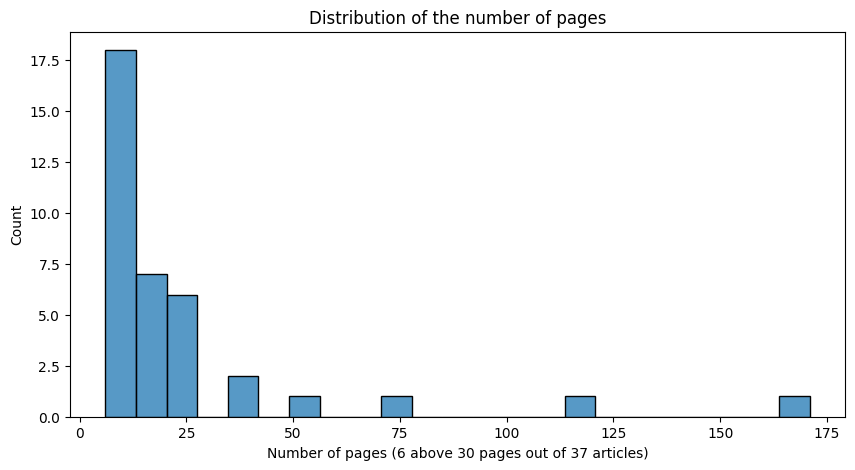

Proportion of articles with more than 30 pages: 16.22%
31 articles indexed in the knowledge base
CPU times: total: 328 ms
Wall time: 2.24 s


In [23]:
%%time

kb_articles = structure_kb("kb_articles", kb_articles, verbose=False)
plt.figure(figsize=(10, 5))
sns.histplot(kb_articles.pages)
plt.title("Distribution of the number of pages")
plt.xlabel(f"Number of pages ({len(kb_articles[kb_articles.pages > 30])} above 30 pages out of {len(kb_articles)} articles)")
plt.show()
# It seems that the majority of the articles have less than 30 pages which should be a good cut-off point
print(f"Proportion of articles with more than 30 pages: {len(kb_articles[kb_articles.pages > 30])/len(kb_articles):.2%}")

# Remove articles with more than 30 pages
kb_articles_poc = kb_articles[kb_articles.pages <= 30]
kb_articles_poc.reset_index(inplace=True, drop=True)
# kb_articles_poc.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file
print(f"{len(kb_articles_poc)} articles indexed in the knowledge base")

## 1.2. Extract the abstracts

We will look at the first page, extract the text, set all characters to lowercase and then look for the word `abstract` to find the beginning of the abstract. Then, we will look for `introduction` to mark the end of the abstract. If `introduction` cannot be found, we will take the first 512 characters.

In [24]:
for path in kb_articles_poc.path:
    with fitz.open(path) as doc:
        text = ""
        text += doc[0].get_textpage().extractText()
        try:
            print("introduction" in text.lower().split("abstract")[1])
        except:
            print(path)

# In some pdf files (elsevier), the abstract cannot be found >>> Regular expression to find the abstract even with spaces
# ex: pdf with index 7 has "a b s t r a c t" instead of abstract
# In some pdf files, the introduction cannot be found >>> Take the 3 first pages instead of the first one
# ex: pdf with index 5 has the introduction on the second page

True
True
True
True
True
False
True
kb_articles\Climate risks and financial stability Evidence from the European financial system - JFS 2023.pdf
True
True
True
True
True
False
True
True
True
True
True
kb_articles\Lee et al - 2021 - Graph CNN credit default prediction.pdf
True
True
True
kb_articles\Ma et al - 2018 - Study on a prediction of P2P network loan LGBM XGB.pdf
True
True
True
kb_articles\Starosa - LGD decomposition using mixture distributions nof in-default events - EJOR 2023.pdf
True
True
True


In [25]:
def extract_abstract(path, char_max=1000):
    """Extract the abstract from a pdf file

    Parameters
    ----------
    path : str
        Path to the pdf file
    char_max : int, optional
        Maximum number of characters to extract if introduction not found, by default 1000
    
    Returns
    -------
    str
        Abstract of the pdf file
    """
    with fitz.open(path) as doc:
        text = ""
        # Add two extra pages to the text
        for i in range(3):
            text += doc[i].get_textpage().extractText().lower()
        # Find the abstract with white spaces inbetween characters
        ret = None
        s=0
        while not ret and s<3:
            search = "a.{"+str(s)+"}b.{"+str(s)+"}s.{"+str(s)+"}t.{"+str(s)+"}r.{"+str(s)+"}a.{"+str(s)+"}c.{"+str(s)+"}t"
            ret = re.search(search, text)
            s+= not ret
        abstract_unbounded = re.split(search, text)[1]
        # Find the introduction with white spaces inbetween characters
        ret = None
        s=0
        while not ret and s<3:
            search = "i.{"+str(s)+"}n.{"+str(s)+"}t.{"+str(s)+"}r.{"+str(s)+"}o.{"+str(s)+"}d.{"+str(s)+"}u.{"+str(s)+\
            "}c.{"+str(s)+"}t.{"+str(s)+"}i.{"+str(s)+"}o.{"+str(s)+"}n"
            ret = re.search(search, text)
            i+= not ret
        if not ret:
            abstract = abstract_unbounded[:char_max]
        abstract = re.split(search, abstract_unbounded)[0]
        return abstract

In [26]:
%%time

# for path in kb_articles_poc.path:
#     try:
#         print(f"Length:{len(extract_abstract(path))}")
#     except:
#         print(path)
## The trouble shooting has worked!

kb_articles = pd.read_excel("kb_articles/AAA_index.xlsx")
kb_articles['abstract'] = kb_articles.path.progress_apply(extract_abstract)
# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file


100%|██████████| 29/29 [00:00<00:00, 42.28it/s]

CPU times: total: 1 s
Wall time: 2.68 s


## 1.3. Validation framework

In order to validate our semantic search engine, we will use text summarization to create a summary of the abstracts. We use the `text_summarization` developed by [Falconsai](https://huggingface.co/Falconsai/text_summarization) and set a maximum length of 50 words. These summaries will be used as queries for our semantic search engine. We can then validate the engine by checking if the original article is in fact matching the query.

In [27]:
def create_validation_query(abstract, max_length=50):
    """Create a validation query from the abstract

    Parameters
    ----------
    abstract : str
        Abstract of the article
    max_length : int, optional
        Maximum number of words in the query, by default 50
    
    Returns
    -------
    str
        Validation query
    """
    summary = summarizer(abstract, max_length=max_length)
    return summary[0]['summary_text']

In [28]:
%%time

# We create a validation query from each abstract
kb_articles = pd.read_excel("kb_articles/AAA_index.xlsx")
if 'validation_query' not in kb_articles.columns:
    kb_articles['validation_query'] = kb_articles.abstract.progress_apply(create_validation_query)
else:
    print("Validation query already created")

# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file

Validation query already created
CPU times: total: 0 ns
Wall time: 6.97 ms


While reading the summary queries, we notice that some articles are duplicates with different titles.
- `Credit scroring models v2.0 submitted IRFA` and `Dessain - 2024 - Credit scoring performance metrics` are the same article
- `Dushimimana et al - 2020 - Use of machine learning techniques to create a credit score model for airtime loans` and `Dushimimana et al. - 2020 - Use of machine learning techniques to create a credit score model for airtime loans` are the same article

Thanks to this first application of NLP (through text summarization), we are already able to explore the structure of our knowledge base and identify duplicates which we can remove.

In [29]:
kb_articles = kb_articles[np.logical_not(kb_articles.validation_query.duplicated()).tolist()].reset_index(drop=True)
# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file

Now we can create a performance metric for our semantic search engine. The score will be very simple: 1 if the original article is returned, 0 otherwise. We will then compute the average score for all articles. The `retrieval_score` will then be the proportion of articles that are correctly returned by the semantic search engine (based on the validation query). We will keep track of the `retrieval_score` for each iteration in our training (kept in the `retrieval_logs` excel file).

In [30]:
# retrieval_logs = pd.DataFrame(columns=['embedding', 'retriever', 'retrieval_score', 'time_stamp'])
# retrieval_logs.to_excel("retrieval_logs.xlsx", index=False)

def retrieval_score(retriever, index = "kb_articles/AAA_index.xlsx", name_col="title", query_col="validation_query", verbose=True):
    """Get the retrieval score of a retriever

    Parameters
    ----------
    retriever : function
        Returns the title of the retrieved article given a query
    index : str, optional
        Path to the knowledge base index, by default "kb_articles/AAA_index.xlsx"
    name_col : str, optional
        Name of the column containing the titles, by default "title"
    query_col : str, optional
        Name of the column containing the validation queries, by default "validation_query"
    verbose : bool, optional
        Print the execution details, by default True

    Returns
    -------
    float
        Proportion of retrieved articles
    """
    index = pd.read_excel(index)
    def retrieve(query):
        return retriever(query)
    retrieved = 0
    observations = 0
    for _,row in index.iterrows():
        observations += 1
        if verbose:
            print(f"-| {observations} |-"+"-"*(10-len(str(observations))))
        query = row[query_col]
        if verbose:
            print(f"   Query: {query}")
        results = retrieve(query)
        if verbose:
            print(f"   Results: {results}")
        if row[name_col] == results:
            retrieved += 1
            if verbose:
                print("   > Retrieved!")
        else:
            if verbose:
                print("   > Not retrieved!")
    return retrieved/observations

def log_retriever(
        embedding_name, retriever_name, retriever, scorer=retrieval_score,
        logs="retrieval_logs.xlsx", verbose=True):
    """Log the retrieval score of a retriever

    Parameters
    ----------
    embedding_name : str
        Name of the embedding
    retriever_name : str
        Name of the retriever
    retriever : function
        Returns the title of the retrieved article given a query
    scorer : function
        Returns the retrieval score of a retriever
    logs : str, optional
        Path to the logs, by default "retrieval_logs.xlsx"
    verbose : bool, optional
        Print the execution details, by default True
    
    Returns
    -------
    logs_df : dataframe
        Logs of the retrievers
    """
    score = scorer(retriever, verbose=False)
    if verbose:
        print(f"Retrieval score of {score:.2%}")
    logs_df = pd.read_excel(logs)
    if verbose:
        print("   Logging experiment...")
    if embedding_name is None:
        embedding_name = input("What embedding did you use? ")
    if retriever_name is None:
        retriever_name = input("What retriever did you use? ")
    time_stamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    existing_combinations = [logs_df.embedding[i]+logs_df.retriever[i] for i in range(len(logs_df))]
    if embedding_name+retriever_name not in existing_combinations:
        logs_df.loc[len(logs_df)] = [embedding_name, retriever_name, score, time_stamp]
        logs_df.sort_values(by="retrieval_score", ascending=False, inplace=True)
        logs_df.to_excel(logs, index=False)
        if verbose:
            print("   Experiment logged.")
    else:
        if verbose:
            print("   Experiment already logged.")
    return logs_df

In [31]:
# Test the validation framework with mock retrievers

def ideal_retriever(query, index = "kb_articles/AAA_index.xlsx"):
    index = pd.read_excel(index)
    return index[index.validation_query == query].title.values[0]

def random_retriever(query, index = "kb_articles/AAA_index.xlsx"):
    index = pd.read_excel(index)
    return np.random.choice(index.title.values)

# Log the retrieval score of the mock retrievers
_ = log_retriever(
    embedding_name="Fake embedding", retriever_name="Ideal retriever", retriever=ideal_retriever,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
np.random.seed(42)
log_retriever(
    embedding_name="Fake embedding", retriever_name="Random retriever", retriever=random_retriever,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)

Retrieval score of 100.00%
   Logging experiment...
   Experiment already logged.
Retrieval score of 6.90%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,retrieval_score,time_stamp
0,Fake embedding,Ideal retriever,1.000000,2024-01-30 13:29
1,Spacy without lemmatization,cos_sim,0.965517,2024-01-30 16:36
2,Spacy with lemmatization,cos_sim,0.965517,2024-01-30 16:36
3,Spacy with lemmatization,dot_score,0.827586,2024-01-30 16:40
4,Spacy without lemmatization,dot_score,0.620690,2024-01-30 16:40
5,BOW without prep,cos_sim,0.482759,2024-01-30 14:07
6,Fake embedding,Random retriever,0.068966,2024-01-30 13:29
7,BOW without prep,dot_score,0.034483,2024-01-30 14:10


## 1.4. Try different combinations of embeddings and retrieval models

Now that we have a knowledge base, the abstracts of the different articles, and a validation framework, we can start trying out different combinations of embeddings and retrieval models to find the most effective semantic search engine. We will try out three embeddings and three retrieval models. The embeddings are:
- `Own embedding`: we will use a self-defined Bag of Words embedding as a baseline embedding.
- `Pretrained embeddings`: we will then use pretrained embeddings from the [sentence-transformers](https://www.sbert.net/) library.

For each of these embeddings, we will use two different ways of retrieving the most similar document:
- `dot_score`: dot product between the embeddings
- `cos_sim`: cosine similarity between the embeddings

In [32]:
# Set up our 'home-made' vectorstore
embeddings = pd.read_excel("kb_articles/AAA_index.xlsx").copy()
embeddings.columns
embeddings.drop(columns=['pages','path'], inplace=True)
# embeddings[['title','validation_query', 'abstract']].to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

### A. BOW on a character level

We start by using the BOW embedding without tokenizing and lemmatizing upfront. We'll test the three retrieval models on this embedding.

In [33]:
embeddings = pd.read_pickle("embeddings.pkl")

# BOW embedding: source https://github.com/MathieuDemarets/vlerick-mai-nlp-2023/blob/Local/ASS1%20Modelling.ipynb
# > Reused vocabBOW

def vocabBOW(df, vocab_col='abstract', vocab_size=1000, verbose=False):
    """Creates a vocabulary of the most common words in the corpus and maps each word to an integer

    Parameters
    ----------
    df : DataFrame
        Corpus of documents
    vocab_col : str, optional
        Name of the column containing the documents, by default 'abstract'
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    verbose : bool, optional
        Display details, by default False

    Returns
    -------
    tokenMap : dict
        Word to integer mapping
    tokenMapInverse : dict
        Integer to word mapping
    tokenFreq : Counter
        Word frequencies
    """
    tokenFreq = Counter()
    df[vocab_col].progress_apply(lambda x: tokenFreq.update(x))

    if verbose:
        print(f"Total number of words: {sum(tokenFreq.values())}")
        print(f"Number of unique words: {len(tokenFreq)}")
        print(f"Most common words: {tokenFreq.most_common(5)}")
        print(f"Least common words: {tokenFreq.most_common()[:-5:-1]}")
    
    tokenMap = {k: i+1 for i, (k, _) in enumerate(tokenFreq.most_common(vocab_size-1))} # -1 to account for the <oov> token
    tokenMap["<oov>"]=0 # Out of vocabulary token to account for words not in the vocabulary
    tokenMapInverse = {v: k for k,v in tokenMap.items()}

    return tokenMap, tokenMapInverse, tokenFreq

tokenMap, tokenMapInverse, tokenFreq = vocabBOW(embeddings, vocab_size=1000, verbose=True) 

# > Reused embedBOW

def embedBOW(example, vocab_size=1000, tokenMap=tokenMap):
    """Embeds a document as a Bag of Words vector

    Parameters
    ----------
    example : list
        List of tokens
    vocab_size : int, optional
        Size of the vocabulary, by default 1000
    tokenMap : dict, optional
        Word to integer mapping, by default tokenMap
    
    Returns
    -------
    embedding : np.array
        Bag of Words vector
    """
    embedding = np.zeros(vocab_size)
    for token in example:
        try:
            tokenIndex = tokenMap[token] # get index of token in vocabulary
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        embedding[tokenIndex] = embedding[tokenIndex] + 1 # increment count of token
    return embedding

# embeddings["embeddedBOW"] = embeddings['abstract'].progress_apply(embedBOW) 
# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

100%|██████████| 29/29 [00:00<?, ?it/s]

Total number of words: 36423
Number of unique words: 63
Most common words: [(' ', 4835), ('e', 3658), ('t', 2631), ('i', 2513), ('a', 2452)]
Least common words: [('©', 1), ('$', 1), (']', 1), ('[', 1)]


In [34]:
retriever_dict = {}

def BOW_char_cos(query):
    embedded_query = embedBOW(query)
    embedded_corpus = embeddings["embeddedBOW"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["BOW without prep cos"] = [BOW_char_cos, "BOW without prep", "cos_sim"]

def BOW_char_dot(query):
    embedded_query = embedBOW(query)
    embedded_corpus = embeddings["embeddedBOW"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["BOW without prep dot"] = [BOW_char_dot, "BOW without prep", "dot_score"]

# Log the retrieval score of the BOW_char_cos retriever
log_retriever(
    embedding_name="BOW without prep", retriever_name="cos_sim", retriever=BOW_char_cos,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
log_retriever(
    embedding_name="BOW without prep", retriever_name="dot_score", retriever=BOW_char_dot,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)

c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\sentence_transformers\util.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  b = torch.tensor(b)


Retrieval score of 48.28%
   Logging experiment...
   Experiment already logged.
Retrieval score of 3.45%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,retrieval_score,time_stamp
0,Fake embedding,Ideal retriever,1.000000,2024-01-30 13:29
1,Spacy without lemmatization,cos_sim,0.965517,2024-01-30 16:36
2,Spacy with lemmatization,cos_sim,0.965517,2024-01-30 16:36
3,Spacy with lemmatization,dot_score,0.827586,2024-01-30 16:40
4,Spacy without lemmatization,dot_score,0.620690,2024-01-30 16:40
5,BOW without prep,cos_sim,0.482759,2024-01-30 14:07
6,Fake embedding,Random retriever,0.068966,2024-01-30 13:29
7,BOW without prep,dot_score,0.034483,2024-01-30 14:10


### B. BOW based on the spacy tokenizer

In the previous embedding, we focussed on the frequency of characters only. Surprisingly, this naive embedding already identified 48% of the articles correctly. We will now use the spacy tokenizer to tokenize the abstracts, create a new vocabulary and a new embedding. 

We expect a better performance with this embedding as the tokenizer will clean the abstract from punctuation and stop words. We will also test one embedding with lemmatization and one without (as maybe the nuance might help differentiate better between articles). We will then test the two retrieval models with the query tokenization.

In [35]:
# Spacy tokenizer: source https://github.com/MathieuDemarets/vlerick-mai-nlp-2023/blob/Local/ASS1%20Exploration.ipynb

# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
# We made sure that no text was over 500k characters so no try except needed to catch the exception
def spacy_tokenizer(sentence, lemmatize=True):
    """Transforms a sentence into a list of (lemma) tokens and remove stop words and punctuation.

    Parameters
    ----------
    sentence : str
        Input sentence.
    lemmatize : bool, optional
        Whether to lemmatize the tokens, by default True.

    Returns
    -------
    list
        List of lemma tokens.
    """
    mytokens = nlp(sentence.lower())
    mytokens = [word for word in mytokens if not word.is_oov and not word.is_stop and not word.is_punct]
    if lemmatize:
        mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    else:
        mytokens = [word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

In [36]:
embeddings = pd.read_pickle("embeddings.pkl")
spacy_tokenizer_no_lemma = lambda x: spacy_tokenizer(x, lemmatize=False)
embeddings["tokens_no_lemma"] = embeddings["abstract"].progress_apply(spacy_tokenizer_no_lemma)
embeddings["tokens_lemma"] = embeddings["abstract"].progress_apply(spacy_tokenizer)
# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

100%|██████████| 29/29 [00:00<00:00, 29.26it/s]


In [37]:
# Create the new embedding functions and abstract embeddings for the tokenized abstracts

# No lemma
tokenMap_no_lemma, tokenMapInverse_no_lemma, tokenFreq_no_lemma = vocabBOW(embeddings, vocab_col='tokens_no_lemma', vocab_size=1000, verbose=True)
embedBOW_no_lemma = lambda x: embedBOW(x, vocab_size=1000, tokenMap=tokenMap_no_lemma)
embeddings["embeddedBOW_no_lemma"] = embeddings['tokens_no_lemma'].progress_apply(embedBOW_no_lemma)

# Lemma
tokenMap_lemma, tokenMapInverse_lemma, tokenFreq_lemma = vocabBOW(embeddings, vocab_col='tokens_lemma', vocab_size=1000, verbose=True)
embedBOW_lemma = lambda x: embedBOW(x, vocab_size=1000, tokenMap=tokenMap_lemma)
embeddings["embeddedBOW_lemma"] = embeddings['tokens_lemma'].progress_apply(embedBOW_lemma)

# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

100%|██████████| 29/29 [00:00<00:00, 1870.04it/s]


Total number of words: 3253
Number of unique words: 1368
Most common words: [('models', 59), ('financial', 52), ('model', 39), ('learning', 36), ('data', 33)]
Least common words: [('parameters', 1), ('release', 1), ('professionals', 1), ('ciency', 1)]


100%|██████████| 29/29 [00:00<00:00, 14540.92it/s]


Total number of words: 3232
Number of unique words: 1144
Most common words: [('model', 98), ('financial', 53), ('default', 32), ('datum', 31), ('learning', 30)]
Least common words: [('parameter', 1), ('professional', 1), ('ciency', 1), ('potentially', 1)]


100%|██████████| 29/29 [00:00<?, ?it/s]


In [38]:
# Create the new retrievers based on the two new abstract embeddings and the embedding functions

# 1. Spacy without lemmatization and cosine similarity

def spacy_no_lemma_cos(query):
    embedded_query = embedBOW_no_lemma(spacy_tokenizer_no_lemma(query))
    embedded_corpus = embeddings["embeddedBOW_no_lemma"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Spacy without lemmatization cos"] = [spacy_no_lemma_cos, "Spacy without lemmatization", "cos_sim"]

# 2. Spacy without lemmatization and dot product

def spacy_no_lemma_dot(query):
    embedded_query = embedBOW_no_lemma(spacy_tokenizer_no_lemma(query))
    embedded_corpus = embeddings["embeddedBOW_no_lemma"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Spacy without lemmatization dot"] = [spacy_no_lemma_dot, "Spacy without lemmatization", "dot_score"]

# 3. Spacy with lemmatization and cosine similarity

def spacy_lemma_cos(query):
    embedded_query = embedBOW_lemma(spacy_tokenizer(query))
    embedded_corpus = embeddings["embeddedBOW_lemma"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Spacy with lemmatization cos"] = [spacy_lemma_cos, "Spacy with lemmatization", "cos_sim"]

# 4. Spacy with lemmatization and dot product

def spacy_lemma_dot(query):
    embedded_query = embedBOW_lemma(spacy_tokenizer(query))
    embedded_corpus = embeddings["embeddedBOW_lemma"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Spacy with lemmatization dot"] = [spacy_lemma_dot, "Spacy with lemmatization", "dot_score"]

In [39]:
# Log the retrieval score of the new retrievers

_ = log_retriever(
    embedding_name="Spacy without lemmatization", retriever_name="cos_sim", retriever=spacy_no_lemma_cos,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
_ = log_retriever(
    embedding_name="Spacy without lemmatization", retriever_name="dot_score", retriever=spacy_no_lemma_dot,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
_ = log_retriever(
    embedding_name="Spacy with lemmatization", retriever_name="cos_sim", retriever=spacy_lemma_cos,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)
log_retriever(
    embedding_name="Spacy with lemmatization", retriever_name="dot_score", retriever=spacy_lemma_dot,
    scorer=retrieval_score, logs="retrieval_logs.xlsx", verbose=True)

Retrieval score of 96.55%
   Logging experiment...
   Experiment already logged.
Retrieval score of 62.07%
   Logging experiment...
   Experiment already logged.
Retrieval score of 96.55%
   Logging experiment...
   Experiment already logged.
Retrieval score of 82.76%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,retrieval_score,time_stamp
0,Fake embedding,Ideal retriever,1.000000,2024-01-30 13:29
1,Spacy without lemmatization,cos_sim,0.965517,2024-01-30 16:36
2,Spacy with lemmatization,cos_sim,0.965517,2024-01-30 16:36
3,Spacy with lemmatization,dot_score,0.827586,2024-01-30 16:40
4,Spacy without lemmatization,dot_score,0.620690,2024-01-30 16:40
5,BOW without prep,cos_sim,0.482759,2024-01-30 14:07
6,Fake embedding,Random retriever,0.068966,2024-01-30 13:29
7,BOW without prep,dot_score,0.034483,2024-01-30 14:10


In [40]:
print(f"Our best model achieves a {retrieval_score(spacy_no_lemma_cos, verbose=True):.2%} retrieval score")

-| 1 |----------
   Query: neural additive models (nams) combine expressivity of dnns with inherent intelligibility of generalized additive models . nams learn a linear combination of neural networks that each attend to a single input feature
   Results: Agarwal et al - 2021 - neural additive models interpretable machine learning with neural nets - NeurIPS-2021-
   > Retrieved!
-| 2 |----------
   Query: the model predictive accuracy assessment represents a basic requirement . on the one hand, literature provides several predictive accuracy measures but, on the other hand, these measures are typically computationally intensive or are based on subjective criteria .
   Results: Agosto et al - 2020  - A new proposal to improve credit scoring model predictive accuracy
   > Retrieved!
-| 3 |----------
   Query: our approach is considering the cost matrix and cumulative profit chart for setting the threshold value . in the paper we examine the performance of several models trained with homog

When we use the spacy tokenization (with or without lemmatization), we see that the `cos_sim` retrieval model performs very well. In fact, it makes a single mistake out of the 29 articles in the knowledge base. Because of this, we will add two steps to our initial workflow:
- 1. Try to understand why there was a mistake
- 2. Develop the validation framework to make the queries more realistic (further from the abstracts) and have a more robust performance metric.

In [41]:
embedded_validation_query = embeddings['validation_query'].progress_apply(spacy_tokenizer_no_lemma)
embedded_validation_query = embedded_validation_query.progress_apply(embedBOW_no_lemma)

100%|██████████| 29/29 [00:00<?, ?it/s]


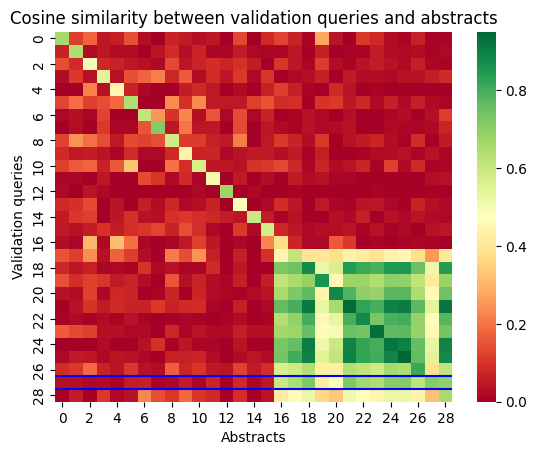

In [42]:
sns.heatmap(pd.DataFrame(util.cos_sim(embedded_validation_query, embeddings["embeddedBOW_no_lemma"])),
            cmap="RdYlGn")
# plot a box around the query 21
plt.plot([0, 29], [27, 27], 'b-')
plt.plot([0, 29], [28, 28], 'b-')
plt.title("Cosine similarity between validation queries and abstracts")
plt.xlabel("Abstracts")
plt.ylabel("Validation queries")
plt.show()

> 1. When we look at the similarity between the embeddings of the query and the articles (which we use for the retrieval), we get a better idea of the performance of the semantic search engine. We see in fact that the search engine is really quite good at differentiation the 15 first articles based on their validation query. However, it is a lot harder for the next 13 articles. For most of them, the retrieval is still correct because the correlation between the query and its original article is higher than the correlation between the query and the other articles. However, for the second last query, the correlation between the query and the original article is lower and the engine cannot differentiate it from the other similar articles.

The similarity between the last articles can be caused because a higher number of 'Out-of-Vocabulary' words. This is a limitation of the BOW approach (we limited the vocabulary to 1000 words). Then the articles with more OOV will be more similar to each other as their embeddings will be more similar ([HIGH, ..., ...]). We'll check this below. 

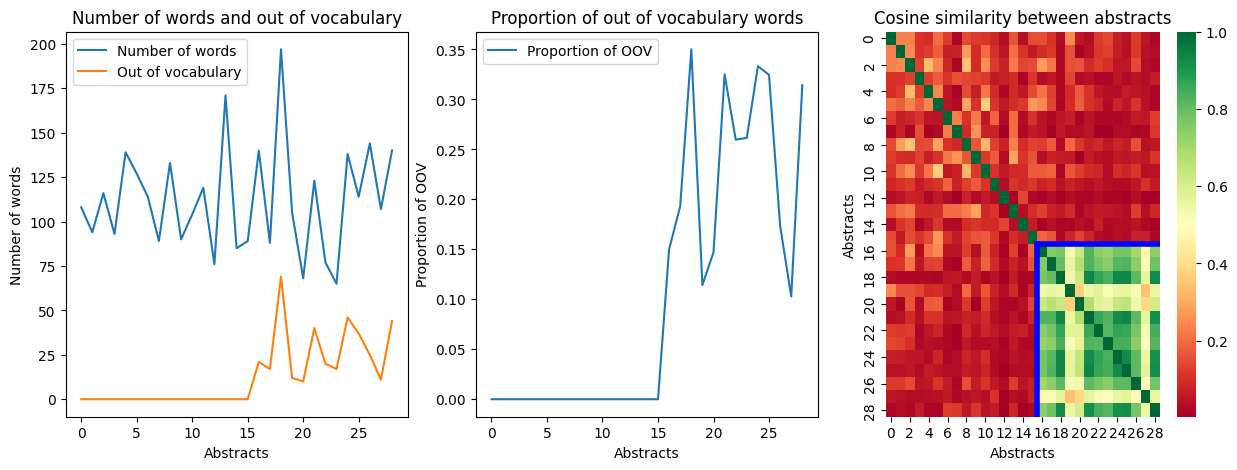

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot([sum(embedding) for embedding in embeddings["embeddedBOW_no_lemma"]], label="Number of words")
ax[0].plot([embedding[0] for embedding in embeddings["embeddedBOW_no_lemma"]], label="Out of vocabulary")
ax[0].set_title("Number of words and out of vocabulary")
ax[0].set_xlabel("Abstracts")
ax[0].set_ylabel("Number of words")
ax[0].legend()

ax[1].plot([embedding[0]/sum(embedding) for embedding in embeddings["embeddedBOW_no_lemma"]], label="Proportion of OOV")
ax[1].set_title("Proportion of out of vocabulary words")
ax[1].set_xlabel("Abstracts")
ax[1].set_ylabel("Proportion of OOV")
ax[1].legend()

sns.heatmap(
    pd.DataFrame(util.cos_sim(embeddings["embeddedBOW_no_lemma"], embeddings["embeddedBOW_no_lemma"])),
    cmap="RdYlGn", ax=ax[2])
plt.plot([16, 29], [16, 16], 'b-', linewidth=4)
plt.plot([16, 16], [16, 29], 'b-', linewidth=4)
ax[2].set_title("Cosine similarity between abstracts")
ax[2].set_xlabel("Abstracts")
ax[2].set_ylabel("Abstracts")

plt.show()

> 2. We confirm our hypothesis that the BOW embedding is not able to differentiate between articles with a high number of OOV words (that are then quite similar to one another). We will therefore take two actions. First, we will `develop a more robust validation framework` to test the semantic search engine on three different types of queries: the summary of the abstract, a rephrased summary, and a question drawn from the summary (from closest to furthest from the abstract). Second, we will try a BOW embedding with a larger vocabulary to avoid the OOV issue we identifies and `try out the pretrained embeddings` to see if they perform better (no OOV issue and smaller embedding space).

In [44]:
# > Upcoming code inspired from https://colab.research.google.com/drive/1U05kuyx_EDtuSpa8LggNtpYax7FFC7O0?usp=sharing#scrollTo=uhDYYML17-Ds
# > Original function and content for the system role

from llamaapi import LlamaAPI
import json

llama = LlamaAPI("LL-DtYGko3WDDw6ylKszULyulXS4HFAIpu7xUG5ypGNPXtJWaur6aQNmWCTJ96sQvMf")

def rephrase_query(query, context):
    """Rephrase the query using the Llama API and the context

    Parameters
    ----------
    query : str
        Query to rephrase

    Returns
    -------
    str
        Rephrased query
    """
    api_request_json = {
        "model": "llama-13b-chat", # the 70B model is too slow for inference
        "messages": [
            {"role": "system", "content": context},
            {"role": "user", "content": query},
        ]
    }
    response = llama.run(api_request_json)
    output = json.loads(response.text)
    return output["choices"][0]['message']['content']

In [45]:
kb_articles = pd.read_excel("kb_articles/AAA_index.xlsx")
# Example of the three types of queries to use in the validation
if 'rephrased_validation_query' in kb_articles.columns:
    for i in range(5):
        original = kb_articles.iloc[i].validation_query.replace("\n", " ")
        rephrased = kb_articles.iloc[i].rephrased_validation_query.replace("\n", " ")
        question = kb_articles.iloc[i].validation_question.replace("\n", " ")
        print(f"Article {i}")
        print(f"   Original query: {original}")
        print(f"   Rephrased query: {rephrased}")
        print(f"   Question query: {question}")

# output = rephrase_query(kb_articles.iloc[0].validation_query)
# print(f"Original query: {kb_articles.iloc[0].validation_query}")
# print(f"Rephrased query: {output}")
# Validated!

Article 0
   Original query: neural additive models (nams) combine expressivity of dnns with inherent intelligibility of generalized additive models . nams learn a linear combination of neural networks that each attend to a single input feature
   Rephrased query: Sure! Here's a paraphrase of the phrase you provided, using simpler language:  Neural additive models (NAMs) bring together the best of both worlds: the power of deep neural networks (DNNs) and the interpretable structure of generalized additive models (GAMs). NAMs learn to combine multiple neural networks, each one focusing on a single input feature.
   Question query: What features does the linear combination of neural networks in Neural Additive Models (NAMs) attend to?
Article 1
   Original query: the model predictive accuracy assessment represents a basic requirement . on the one hand, literature provides several predictive accuracy measures but, on the other hand, these measures are typically computationally intensive o

In [46]:
# > Run with the initial 5$ credit from the Llama API: https://www.llama-api.com

# # Rephrase the validation queries to make them closer to realistic text snippets or explanations
# rephraser = lambda x: rephrase_query(
#     x, context="You are a teacher and will rephrase the given phrase to make them easier to understand. Don't say ANYTHING else than the paraphrase. Keep it short")
# if 'rephrased_validation_query' not in kb_articles.columns:
#     kb_articles['rephrased_validation_query'] = kb_articles.validation_query.progress_apply(rephraser)
# # Create a plausible question to ask about the article summary
# questioner = lambda x: rephrase_query(
#     x, context="You are a student and will ask a question specific to the given phrase. Don't say ANYTHING else than the question. Keep it short")
# if 'validation_question' not in kb_articles.columns:
#     kb_articles['validation_question'] = kb_articles.validation_query.progress_apply(questioner)

In [47]:
# kb_articles.to_excel("kb_articles/AAA_index.xlsx", index=False) # avoid overwriting the index file

Now that we have our three sets of queries, we have to fine tune the validation framework to give these three separate scores, we will also add the option to visualize the similarity heatmaps between the query and the articles. We will then test our search engines again.

In [48]:
querie_types = ["validation_query", "rephrased_validation_query", "validation_question"]

# retrieval_logs_3 = pd.DataFrame(columns=['embedding', 'retriever', 'time_stamp']+querie_types)
# retrieval_logs_3.to_excel("retrieval_logs_3.xlsx", index=False)

def log_retriever_3(
        embedding_name, retriever_name, retriever, scorer=retrieval_score, queries = querie_types,
        embedder = embedBOW, logs="retrieval_logs_3.xlsx", verbose=True):
    """Log the retrieval score of a retriever

    Parameters
    ----------
    embedding_name : str
        Name of the embedding
    retriever_name : str
        Name of the retriever
    retriever : function
        Returns the title of the retrieved article given a query
    scorer : function
        Returns the retrieval score of a retriever
    queries : list, optional
        Types of queries to log, by default querie_types (all three types)
    logs : str, optional
        Path to the logs, by default "retrieval_logs.xlsx"
    verbose : bool, optional
        Print the execution details, by default True
    
    Returns
    -------
    logs_df : dataframe
        Logs of the retrievers
    """
    scores = {query: scorer(retriever, query_col=query, verbose=False) for query in queries}
    if verbose:
        for query in queries:
            print(f"Retrieval score on '{query}' of {scores[query]:.2%}")
    logs_df = pd.read_excel(logs)
    if verbose:
        print("   Logging experiment...")
    if embedding_name is None:
        embedding_name = input("What embedding did you use? ")
    if retriever_name is None:
        retriever_name = input("What retriever did you use? ")
    time_stamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    existing_combinations = [logs_df.embedding[i]+logs_df.retriever[i] for i in range(len(logs_df))]
    if embedding_name+retriever_name not in existing_combinations:
        logs_df.loc[len(logs_df)] = [embedding_name, retriever_name, time_stamp, *list(scores.values())]
        logs_df.sort_values(by=queries[-1], ascending=False, inplace=True)
        logs_df.to_excel(logs, index=False)
        if verbose:
            print("   Experiment logged.")
    else:
        if verbose:
            print("   Experiment already logged.")
    return logs_df

In [70]:
# We'll create a function to vizualise the closeness of the queries to the abstracts

def query_closeness(embedding_name, embedding_function):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
    for query in querie_types:
        embedded_validation_query = kb_articles[query].progress_apply(embedding_function)
        sns.heatmap(
            pd.DataFrame(util.cos_sim(embedded_validation_query, embeddings[embedding_name])),
            cmap="RdYlGn", ax=ax[querie_types.index(query)])
        ax[querie_types.index(query)].set_title(f"Similarity with {query}")
        ax[querie_types.index(query)].set_xlabel("Abstracts")
        ax[querie_types.index(query)].set_ylabel(query)

    plt.show()

In [50]:
# for query in querie_types:
#     print(f'{query}: {retrieval_score(spacy_no_lemma_cos, name_col="title", query_col=query, verbose=False):.2%}')

for key in retriever_dict.keys():
    print(f"\n--{key}"+'-'*(50-len(key)))
    retriever = retriever_dict[key]
    logs = log_retriever_3(
        embedding_name=retriever[1], retriever_name=retriever[2], retriever=retriever[0],
        scorer=retrieval_score, queries=querie_types, verbose=True)
logs


--BOW without prep cos------------------------------


Retrieval score on 'validation_query' of 48.28%
Retrieval score on 'rephrased_validation_query' of 17.24%
Retrieval score on 'validation_question' of 13.79%
   Logging experiment...
   Experiment already logged.

--BOW without prep dot------------------------------
Retrieval score on 'validation_query' of 3.45%
Retrieval score on 'rephrased_validation_query' of 3.45%
Retrieval score on 'validation_question' of 3.45%
   Logging experiment...
   Experiment already logged.

--Spacy without lemmatization cos-------------------
Retrieval score on 'validation_query' of 96.55%
Retrieval score on 'rephrased_validation_query' of 24.14%
Retrieval score on 'validation_question' of 37.93%
   Logging experiment...
   Experiment already logged.

--Spacy without lemmatization dot-------------------
Retrieval score on 'validation_query' of 62.07%
Retrieval score on 'rephrased_validation_query' of 3.45%
Retrieval score on 'validation_question' of 13.79%
   Logging experiment...
   Experiment already lo

,embedding,retriever,time_stamp,validation_query,rephrased_validation_query,validation_question
0,Spacy without lemmatization large,cos_sim,2024-02-03 22:45,0.965517,0.965517,0.862069
1,Spacy with lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.275862,0.482759
2,Spacy without lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.241379,0.379310
3,Spacy with lemmatization,dot_score,2024-02-03 14:07,0.827586,0.034483,0.172414
4,Spacy without lemmatization,dot_score,2024-02-03 14:07,0.620690,0.034483,0.137931
5,BOW without prep,cos_sim,2024-02-03 14:04,0.482759,0.172414,0.137931
6,BOW without prep,dot_score,2024-02-03 14:07,0.034483,0.034483,0.034483


 24%|██▍       | 7/29 [00:00<00:00, 68.38it/s]

100%|██████████| 29/29 [00:00<00:00, 117.18it/s]


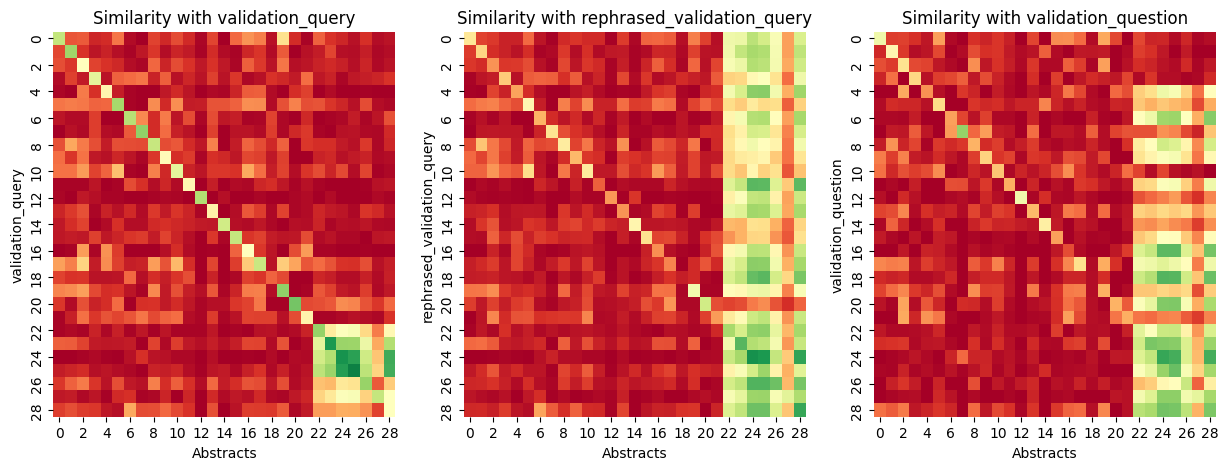

In [51]:
embedder = lambda x: embedBOW_lemma(spacy_tokenizer(x))
query_closeness("embeddedBOW_lemma", embedder)

100%|██████████| 29/29 [00:00<00:00, 123.53it/s]


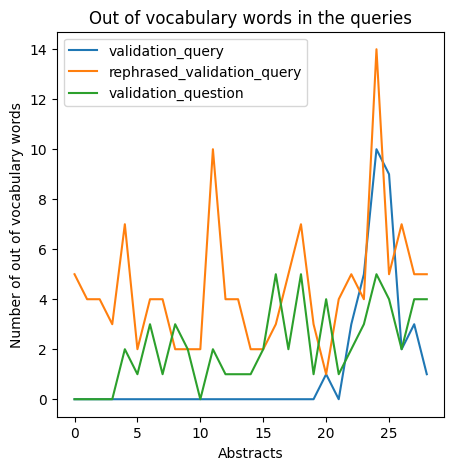

In [52]:
plt.figure(figsize=(5, 5))
for query in querie_types:
    embedded_query = kb_articles[query].progress_apply(embedder)
    plt.plot([embedding[0] for embedding in embedded_query], label=query)
plt.title("Out of vocabulary words in the queries")
plt.xlabel("Abstracts")
plt.ylabel("Number of out of vocabulary words")
plt.legend()
plt.show()

We see that the performance is a lot more nuanced now that we use a more robust validation framework. In fact, the similarities between queries and abstracts are less conclusive when the queries are reformulated. In fact, the last articles have a lot of OOV tokens and the new queries as well. They therefore resonate more (`cos_sim`). Our best performing model is still the `cos_sim` retrieval model with the `spacy tokenizer and lemmatization`. However, we now have a much larger margin of improvement as the validation questions are only correctly answered 48.3% of the time and the rephrased summaries 27.6% of the time.

### C. BOW with a larger vocabulary

It seems that the OOV words are the main issue with our current search engine. We will therefore try the best model (spacy tokenizer and lemmatization with the `cos_sim` retrieval model) with a larger vocabulary.


In [53]:
tokenMapLarge,tokenMapInverseLarge,tokenFreqLarge = vocabBOW(
    embeddings, vocab_col='tokens_lemma', vocab_size=1144, verbose=True)

100%|██████████| 29/29 [00:00<?, ?it/s]

Total number of words: 3232
Number of unique words: 1144
Most common words: [('model', 98), ('financial', 53), ('default', 32), ('datum', 31), ('learning', 30)]
Least common words: [('parameter', 1), ('professional', 1), ('ciency', 1), ('potentially', 1)]


In [54]:
embedBOWLarge = lambda x: embedBOW(x, vocab_size=1144, tokenMap=tokenMapLarge)
embeddings["embeddedBOWLarge"] = embeddings['tokens_lemma'].progress_apply(embedBOWLarge)

# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

100%|██████████| 29/29 [00:00<00:00, 8775.33it/s]


 62%|██████▏   | 18/29 [00:00<00:00, 84.04it/s]

100%|██████████| 29/29 [00:00<00:00, 117.22it/s]


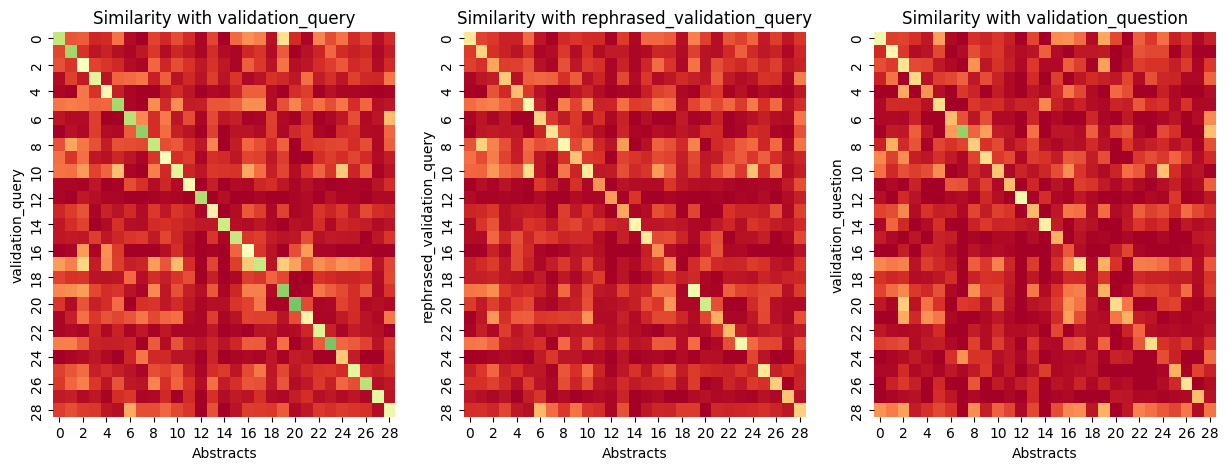

Retrieval score on 'validation_query' of 96.55%
Retrieval score on 'rephrased_validation_query' of 96.55%
Retrieval score on 'validation_question' of 86.21%
   Logging experiment...
   Experiment already logged.


,embedding,retriever,time_stamp,validation_query,rephrased_validation_query,validation_question
0,Spacy without lemmatization large,cos_sim,2024-02-03 22:45,0.965517,0.965517,0.862069
1,Spacy with lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.275862,0.482759
2,Spacy without lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.241379,0.379310
3,Spacy with lemmatization,dot_score,2024-02-03 14:07,0.827586,0.034483,0.172414
4,Spacy without lemmatization,dot_score,2024-02-03 14:07,0.620690,0.034483,0.137931
5,BOW without prep,cos_sim,2024-02-03 14:04,0.482759,0.172414,0.137931
6,BOW without prep,dot_score,2024-02-03 14:07,0.034483,0.034483,0.034483


In [55]:
def spacy_lemma_large_cos(query):
    embedded_query = embedBOWLarge(spacy_tokenizer(query))
    embedded_corpus = embeddings["embeddedBOWLarge"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Spacy without lemmatization cos large"] = [spacy_lemma_large_cos, "Spacy without lemmatization large", "cos_sim"]

embedder = lambda x: embedBOWLarge(spacy_tokenizer(x))
query_closeness("embeddedBOWLarge", embedder)

log_retriever_3(
    embedding_name="Spacy without lemmatization large", retriever_name="cos_sim", retriever=spacy_lemma_large_cos,
    scorer=retrieval_score, queries=querie_types, verbose=True)

We see that the performance is a lot better when we don't limit the vocabulary (limit = count of unique words). The limit to this approach is that the embedding function should be retrained and reapplied when new articles are added to the knowledge base. This is not a scalable solution.

We will therefore try pretrained embeddings that don't have this vocabulary size limitation to see if they can match the performance of the BOW embedding with a larger vocabulary or even improve it.

### D. Pretrained embeddings

In [58]:
# Let's start with the paraphrase-MiniLM-L6-v2 pretrained embedding
# @inproceedings{reimers-2019-sentence-bert,
#     title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",
#     author = "Reimers, Nils and Gurevych, Iryna",
#     booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",
#     month = "11",
#     year = "2019",
#     publisher = "Association for Computational Linguistics",
#     url = "http://arxiv.org/abs/1908.10084",
# }
embeddings = pd.read_pickle("embeddings.pkl")
print(embeddings["tokens_no_lemma"].apply(len).max()) # The maximum number of tokens should be less than 512

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model.max_seq_length = 512 # Increase the max length (x4) to capture more of the content

embed = lambda x: model.encode(x, convert_to_tensor=False)
embeddings["paraphrase-MiniLM-L6-v2"] = embeddings["abstract"].progress_apply(embed)
embeddings["lemma_paraphrase-MiniLM-L6-v2"] = embeddings["tokens_lemma"].progress_apply(
    lambda x: model.encode(" ".join(x), convert_to_tensor=False)
) # We embed the lemmatized tokens to have a first cleaning of the text before embedding

# embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

197


100%|██████████| 29/29 [00:01<00:00, 20.87it/s]


In [63]:
def MiniLM_L6_v2_cos(query):
    embedded_query = model.encode(query, convert_to_tensor=False)
    embedded_corpus = embeddings["paraphrase-MiniLM-L6-v2"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["MiniLM-L6-v2 cos"] = [MiniLM_L6_v2_cos, "MiniLM-L6-v2", "cos_sim"]

def MiniLM_L6_v2_dot(query):
    embedded_query = model.encode(query, convert_to_tensor=False)
    embedded_corpus = embeddings["paraphrase-MiniLM-L6-v2"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["MiniLM-L6-v2 dot"] = [MiniLM_L6_v2_dot, "MiniLM-L6-v2", "dot_score"]

def LemmaMiniLM_L6_v2_cos(query):
    embedded_query = model.encode(query, convert_to_tensor=False)
    embedded_corpus = embeddings["lemma_paraphrase-MiniLM-L6-v2"]
    sim = util.cos_sim(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Lemma MiniLM-L6-v2 cos"] = [LemmaMiniLM_L6_v2_cos, "MiniLM-L6-v2", "cos_sim"]

def LemmaMiniLM_L6_v2_dot(query):
    embedded_query = model.encode(query, convert_to_tensor=False)
    embedded_corpus = embeddings["lemma_paraphrase-MiniLM-L6-v2"]
    sim = util.dot_score(embedded_query, embedded_corpus)
    return embeddings.iloc[int(sim.argmax()),:].title
retriever_dict["Lemma MiniLM-L6-v2 dot"] = [LemmaMiniLM_L6_v2_dot, "MiniLM-L6-v2", "dot_score"]

log_retriever_3(
    embedding_name="MiniLM-L6-v2", retriever_name="cos_sim", retriever=MiniLM_L6_v2_cos,
    scorer=retrieval_score, queries=querie_types, verbose=True)
log_retriever_3(
    embedding_name="MiniLM-L6-v2", retriever_name="dot_score", retriever=MiniLM_L6_v2_dot,
    scorer=retrieval_score, queries=querie_types, verbose=True)
log_retriever_3(
    embedding_name="LemmaMiniLM-L6-v2", retriever_name="cos_sim", retriever=LemmaMiniLM_L6_v2_cos,
    scorer=retrieval_score, queries=querie_types, verbose=True)
log_retriever_3(
    embedding_name="LemmaMiniLM-L6-v2", retriever_name="dot_score", retriever=LemmaMiniLM_L6_v2_dot,
    scorer=retrieval_score, queries=querie_types, verbose=True)

Retrieval score on 'validation_query' of 93.10%
Retrieval score on 'rephrased_validation_query' of 89.66%
Retrieval score on 'validation_question' of 72.41%
   Logging experiment...
   Experiment already logged.
Retrieval score on 'validation_query' of 93.10%
Retrieval score on 'rephrased_validation_query' of 75.86%
Retrieval score on 'validation_question' of 62.07%
   Logging experiment...
   Experiment already logged.
Retrieval score on 'validation_query' of 86.21%
Retrieval score on 'rephrased_validation_query' of 68.97%
Retrieval score on 'validation_question' of 65.52%
   Logging experiment...
   Experiment logged.
Retrieval score on 'validation_query' of 79.31%
Retrieval score on 'rephrased_validation_query' of 62.07%
Retrieval score on 'validation_question' of 65.52%
   Logging experiment...
   Experiment logged.


,embedding,retriever,time_stamp,validation_query,rephrased_validation_query,validation_question
0,Spacy without lemmatization large,cos_sim,2024-02-03 22:45,0.965517,0.965517,0.862069
1,MiniLM-L6-v2,cos_sim,2024-02-04 12:15,0.931034,0.896552,0.724138
2,LemmaMiniLM-L6-v2,cos_sim,2024-02-04 12:26,0.862069,0.689655,0.655172
10,LemmaMiniLM-L6-v2,dot_score,2024-02-04 12:26,0.793103,0.620690,0.655172
3,MiniLM-L6-v2,dot_score,2024-02-04 12:21,0.931034,0.758621,0.620690
4,Spacy with lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.275862,0.482759
5,Spacy without lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.241379,0.379310
6,Spacy with lemmatization,dot_score,2024-02-03 14:07,0.827586,0.034483,0.172414
7,Spacy without lemmatization,dot_score,2024-02-03 14:07,0.620690,0.034483,0.137931
8,BOW without prep,cos_sim,2024-02-03 14:04,0.482759,0.172414,0.137931


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 54.71it/s]


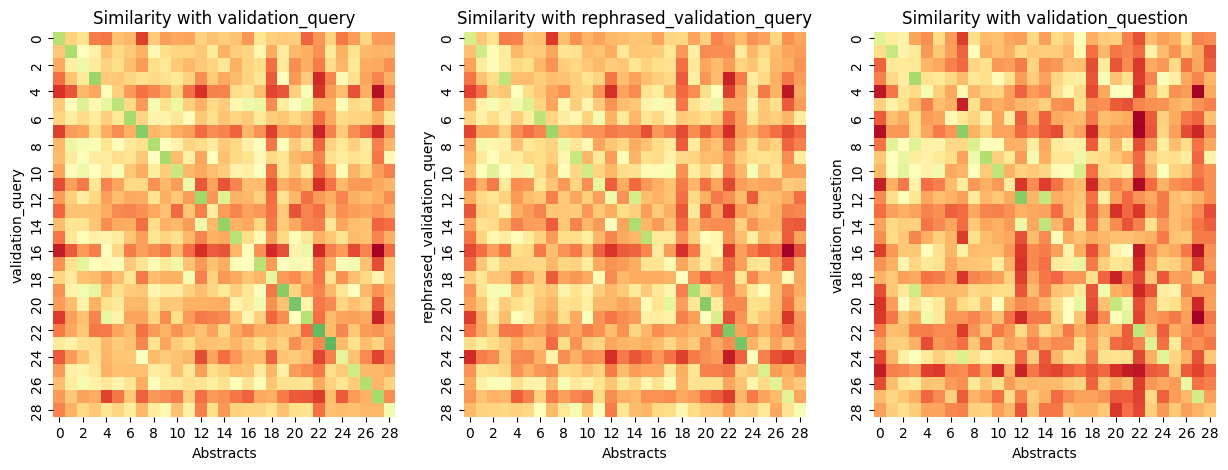

100%|██████████| 29/29 [00:00<00:00, 84.69it/s]


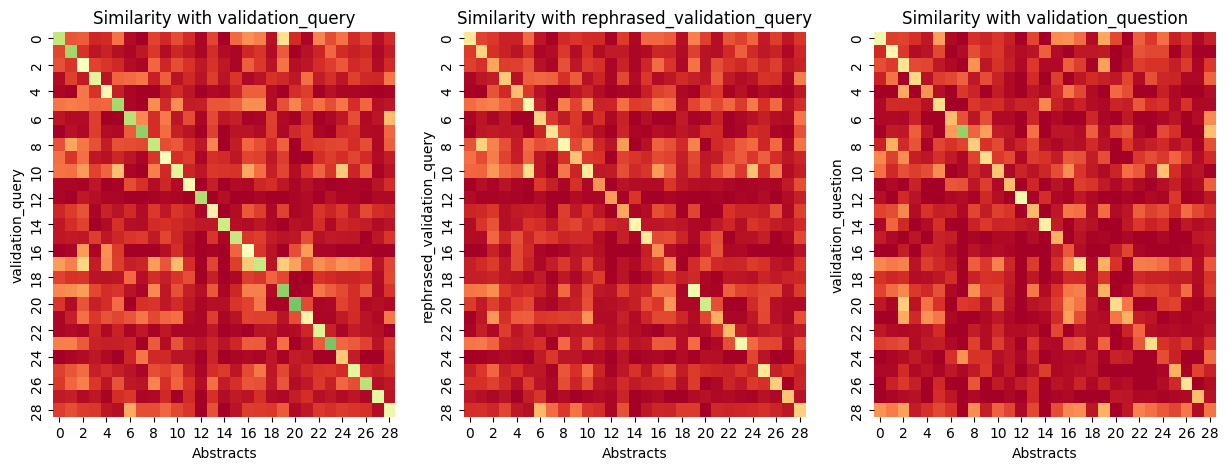

In [62]:
query_closeness("paraphrase-MiniLM-L6-v2", lambda x: model.encode(x, convert_to_tensor=False))
query_closeness("embeddedBOWLarge", lambda x: embedBOWLarge(spacy_tokenizer(x)))
# The MiniLM-L6-v2 model cannot differentiate as well as the BOWLarge model between the different types of queries
# However, it is more robust as the model depend upon the specific vocabulary of the BOWLarge model

In the [semantic search](https://www.sbert.net/examples/applications/semantic-search/README.html) documentation, we read that a major distinction should be made between the symmetric (queries and abstracts of similar size) and the asymmetric semantic search (short queries and long abstracts). Maybe we can improve our semantic search engine by using an assymetric model. We [MSMarco](https://www.sbert.net/docs/pretrained-models/msmarco-v3.html) pretrained embedders fit this purpose and we can use the leaderboard to try the best models for cosine and dot-product similarity.

In [64]:
MSMarcoEncoders = {
    "cos":[
        "msmarco-distilbert-base-v4", # N°1 for cosine similarity
        "msmarco-roberta-base-v3" # N°2 for cosine similarity
    ],
    "dot":[
        "msmarco-distilbert-base-tas-b", # N°1 for dot product
        "msmarco-distilbert-base-dot-prod-v3" # N°2 for dot product
    ]
}

for embedder in MSMarcoEncoders["cos"]+MSMarcoEncoders["dot"]:
    model = SentenceTransformer(embedder)
    model.max_seq_length = 512 # Increase the max length (x4) to capture more of the content
    embeddings[embedder] = embeddings["abstract"].progress_apply(lambda x: model.encode(x, convert_to_tensor=False))
embeddings.to_pickle("embeddings.pkl") # avoid overwriting the embeddings file

1_Pooling/config.json: 100%|██████████| 190/190 [00:00<?, ?B/s] 
README.md: 100%|██████████| 3.71k/3.71k [00:00<?, ?B/s]
config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<?, ?B/s] 
pytorch_model.bin: 100%|██████████| 265M/265M [00:29<00:00, 8.89MB/s] 
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<?, ?B/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 113kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.47MB/s]
tokenizer_config.json: 100%|██████████| 319/319 [00:00<?, ?B/s] 
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.21MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<?, ?B/s] 
README.md: 100%|██████████| 3.70k/3.70k [00:00<?, ?B/s]
config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<?, ?B/s] 
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 1.60MB/s]
pytorch_model.bin: 100%|██████████| 499M/499M [00:52<00:00, 9.56MB/s] 
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<?

In [67]:
def marco_retrievers(embedder, retriever):
    """Facilitate the creation of retrievers based on the MSMarco encoders

    Parameters
    ----------
    embedder : str
        Name of the MSMarco encoder
    retriever : str
        Type of similarity to use (cos or dot)

    Returns
    -------
    function
        Retriever function

    Raises
    ------
    ValueError
        If the retriever is not 'cos' or 'dot'
    """
    model = SentenceTransformer(embedder)
    model.max_seq_length = 512
    def inner(query):
        embedded_query = model.encode(query, convert_to_tensor=False)
        embedded_corpus = embeddings[embedder]
        if retriever == "cos":
            sim = util.cos_sim(embedded_query, embedded_corpus)
        elif retriever == "dot":
            sim = util.dot_score(embedded_query, embedded_corpus)
        else:
            raise ValueError("The retriever must be 'cos' or 'dot'")
        return embeddings.iloc[int(sim.argmax()),:].title
    return inner

for embedder in MSMarcoEncoders["cos"]:
    retriever_dict[embedder+" cos"] = [marco_retrievers(embedder, "cos"), embedder, "cos_sim"]
    retriever = retriever_dict[embedder+" cos"]
    log_retriever_3(
        embedding_name=retriever[1], retriever_name=retriever[2], retriever=retriever[0],
        scorer=retrieval_score, queries=querie_types, verbose=True)
for embedder in MSMarcoEncoders["dot"]:
    retriever_dict[embedder+" dot"] = [marco_retrievers(embedder, "dot"), embedder, "dot_score"]
    retriever = retriever_dict[embedder+" dot"]
    log_retriever_3(
        embedding_name=retriever[1], retriever_name=retriever[2], retriever=retriever[0],
        scorer=retrieval_score, queries=querie_types, verbose=True)

Retrieval score on 'validation_query' of 100.00%
Retrieval score on 'rephrased_validation_query' of 96.55%
Retrieval score on 'validation_question' of 82.76%
   Logging experiment...
   Experiment logged.
Retrieval score on 'validation_query' of 93.10%
Retrieval score on 'rephrased_validation_query' of 89.66%
Retrieval score on 'validation_question' of 86.21%
   Logging experiment...
   Experiment logged.
Retrieval score on 'validation_query' of 100.00%
Retrieval score on 'rephrased_validation_query' of 96.55%
Retrieval score on 'validation_question' of 93.10%
   Logging experiment...
   Experiment logged.
Retrieval score on 'validation_query' of 93.10%
Retrieval score on 'rephrased_validation_query' of 93.10%
Retrieval score on 'validation_question' of 82.76%
   Logging experiment...
   Experiment logged.


100%|██████████| 29/29 [00:01<00:00, 19.84it/s]


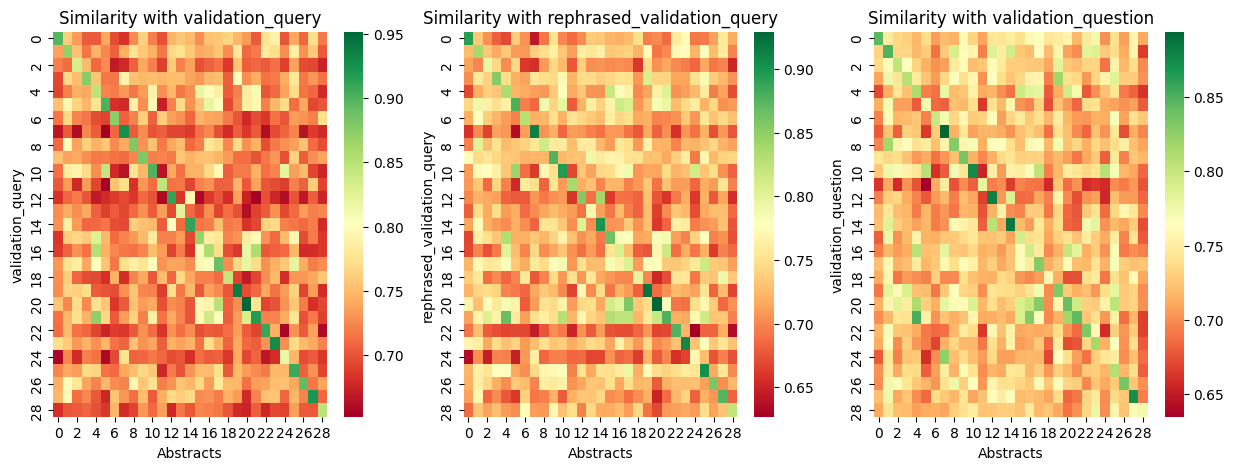

,embedding,retriever,time_stamp,validation_query,rephrased_validation_query,validation_question
0,msmarco-distilbert-base-tas-b,dot_score,2024-02-04 13:08,1.000000,0.965517,0.931034
1,Spacy without lemmatization large,cos_sim,2024-02-03 22:45,0.965517,0.965517,0.862069
2,msmarco-roberta-base-v3,cos_sim,2024-02-04 13:08,0.931034,0.896552,0.862069
3,msmarco-distilbert-base-v4,cos_sim,2024-02-04 13:08,1.000000,0.965517,0.827586
4,msmarco-distilbert-base-dot-prod-v3,dot_score,2024-02-04 13:08,0.931034,0.931034,0.827586
5,MiniLM-L6-v2,cos_sim,2024-02-04 12:15,0.931034,0.896552,0.724138
6,LemmaMiniLM-L6-v2,cos_sim,2024-02-04 12:26,0.862069,0.689655,0.655172
7,LemmaMiniLM-L6-v2,dot_score,2024-02-04 12:26,0.793103,0.620690,0.655172
8,MiniLM-L6-v2,dot_score,2024-02-04 12:21,0.931034,0.758621,0.620690
9,Spacy with lemmatization,cos_sim,2024-02-03 14:07,0.965517,0.275862,0.482759


In [71]:
logs = pd.read_excel("retrieval_logs_3.xlsx")
model = SentenceTransformer("msmarco-distilbert-base-tas-b")
query_closeness("msmarco-distilbert-base-tas-b",lambda x: model.encode(x, convert_to_tensor=False))
logs

C:\Users\User\AppData\Local\Temp\ipykernel_8688\387760306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_search_engines["id"] = top_search_engines.embedding+" & "+top_search_engines.retriever


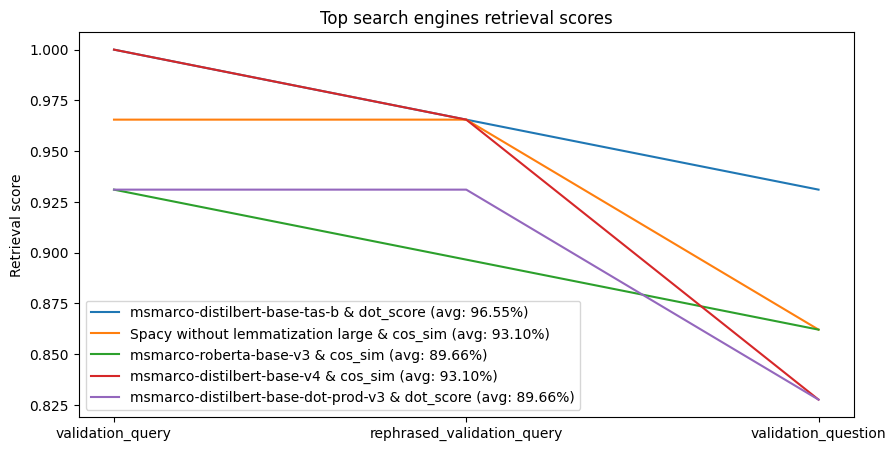

In [96]:
top_search_engines = logs.head(5)

top_search_engines["id"] = top_search_engines.embedding+" & "+top_search_engines.retriever
top_search_engines

plt.figure(figsize=(10, 5))
for index, values in top_search_engines.iterrows():
    plt.plot(values[querie_types], label=f"{values.id} (avg: {values[querie_types].mean():.2%})")
plt.title("Top search engines retrieval scores")
plt.xticks(range(3), querie_types)
plt.ylabel("Retrieval score")
plt.legend()
plt.show()

> After trying 15 different combinations of embeddings and similarity metrics to find the best semantic search engine, we find that the `msmarco-distilbert-base-tas-b` pretrained embedding couples with the `dot_score` similarity metric is the best performing model. It retrieves over 90% of the articles correctly for the three types of queries. It also has the advantage to be independent of the vocabulary size which makes it a scalable solution (as opposed to the BOW embedding with a larger vocabulary which is the second best performing model). We will used this semantic search engine as a base for further functionalities in the rest of the notebook.

In [100]:
SemanticSearchEngine = retriever_dict["msmarco-distilbert-base-tas-b dot"][0]
SemanticSearchEngine("What are good evaluation metrics for credit default models?") # Example of a query

'Credit scroring models v2.0 submitted IRFA'

# 2. Full text retrieval
*back to [Project Overview](#project-overview)*

Now that we have a satisfactory semantic search engine, we can develop functionalities to make it very user friendly. We will namely:
1. Develop a function to retrieve the full text of the most relevant article to the chosen directory
2. Develop a search engine to return the n most relevant articles with the match probability (softmax)
3. Integrate both in an easy user interface

## 2.1. Retrieve the full text of the most relevant article

To do so, we will use the result of our `SemanticSearchEngine` to find the right pdf in the knowledge base (using the index) and copy it to the chosen directory (using the `shutil` library). 

In [122]:
def fetch_article(
        query, output_path="request", search_engine = SemanticSearchEngine, index = "kb_articles/AAA_index.xlsx",
        verbose=True):
    """Fetch the article corresponding to the query

    Parameters
    ----------
    query : str
        Query to search
    output_path : str, optional
        Path to save the article, by default "request"
    search_engine : function, optional
        Search engine to use, by default SemanticSearchEngine
    index : str, optional
        Path to the index, by default "kb_articles/AAA_index.xlsx"
    verbose : bool, optional
        Print the execution details, by default True

    Returns
    -------
    str
        Path to the article (article is copied to the output_path)
    """
    index = pd.read_excel(index)
    if type(query) == str:
        query = [query]
    for search in query:
        if verbose:
            print(f"Searching for '{search}'...")
        title = search_engine(search)
        path = index[index.title == title].path.values[0]
        # check if the path exists and if not, create it
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        # join the path with the filename
        path_out = os.path.join(output_path, f"{title}.pdf")
        path_out = shutil.copy(path, path_out)
        if verbose:
            print(f"   '{title}' copied to:\n   -> '{path_out}'")

In [221]:
questions = [
    "What are good evaluation metrics for credit default models?",
    "What is explainable AI?"
] # Example of questions of a ML engineer
fetch_article(questions, output_path="requests")

Searching for 'What are good evaluation metrics for credit default models?'...
   'Credit scroring models v2.0 submitted IRFA' copied to:
   -> 'requests\Credit scroring models v2.0 submitted IRFA.pdf'
Searching for 'What is explainable AI?'...
   'Nori et al - 2019 - InterpretML A United Framework for Machine Learning Interpretability - arXiv' copied to:
   -> 'requests\Nori et al - 2019 - InterpretML A United Framework for Machine Learning Interpretability - arXiv.pdf'


## 2.2. Develop a search engine for the n most relevant articles

We will have to refine our `SemanticSearchEngine` to enable the n most relevant articles feature. We will use a softmax function applied to the similarity scores to get a probability distribution of the best matches. We will then return the n most relevant articles to the chosen directory.

In [222]:
def SemanticSearchEngine_N(
        query, n=3, softmax=False, output_path=None,
        index="kb_articles/AAA_index.xlsx", verbose=True):
    """Search engine using the msmarco-distilbert-base-tas-b embedding and the dot product

    Parameters
    ----------
    query : str
        Query to search
    n : int, optional
        Number of articles to retrieve, by default 3
    softmax : bool, optional
        Use softmax instead of the score, by default False
    output_path : str, optional
        Path to save the article, by default None

    Returns
    -------
    pd.DataFrame
        Dataframe of the retrieved articles (title, score, pages, abstract, path)
    """
    model = SentenceTransformer("msmarco-distilbert-base-tas-b")
    model.max_seq_length = 512
    embedded_query = model.encode(query, convert_to_tensor=False)
    embedded_corpus = embeddings["msmarco-distilbert-base-tas-b"]
    
    # Get the similarity scores
    sim = util.dot_score(embedded_query, embedded_corpus)
    output = pd.DataFrame(sim).T
    output["Key"] = output.index
    output.columns = ["Score", "Key"]
    rank = "Score"

    # Use softmax if needed
    if softmax:
        def get_softmax(scores):
            return np.exp(scores)/np.exp(scores).sum()
        output["Softmax"] = get_softmax(output.Score.to_list())
        rank = "Softmax"
    output = output.sort_values(by=rank, ascending=False).head(n)
    
    # Copy the articles to the output_path if needed
    if output_path is not None:
        index = pd.read_excel(index)
        if not os.path.exists(output_path):
                os.makedirs(output_path)
        retrieved = pd.merge(output, index, left_on="Key", right_index=True)
        i = 0
        for _, row in retrieved.iterrows():
            i+=1
            path = row.path
            path_out = os.path.join(output_path, f"{row.title}.pdf")
            path_out = shutil.copy(path, path_out)
            if verbose:
                print(f"\nTop {i}: {output.iloc[i-1][rank]:.2f}\n'{row.title}' copied to:\n   -> '{path_out}'")
    return retrieved.loc[:,["title", rank, "pages", "abstract", "path"]]

In [231]:
for question in questions:
    print(f"\n{question}")
    print("-"*len(question))
    display(SemanticSearchEngine_N(question, softmax=False, output_path="requests", verbose=False)) # display is similar to print but with a better format


What are good evaluation metrics for credit default models?
-----------------------------------------------------------


,title,Score,pages,abstract,path
8,Credit scroring models v2.0 submitted IRFA,105.613663,25,\nthis study examines the evaluation of machi...,kb_articles\Credit scroring models v2.0 submit...
2,Aleksandrova and Parusheva - 2021 - Performanc...,100.263458,11,\nthe purpose of this research paper is to pr...,kb_articles\Aleksandrova and Parusheva - 2021 ...
10,Dushimimana et al - 2020 - Use of machine lear...,99.943787,11,: airtime lending default rates are typically ...,kb_articles\Dushimimana et al - 2020 - Use of ...



What is explainable AI?
-----------------------


,title,Score,pages,abstract,path
22,Nori et al - 2019 - InterpretML A United Frame...,94.459373,8,\ninterpretml is an open-source python package...,kb_articles\Nori et al - 2019 - InterpretML A ...
13,Hassan et al - A systematic survey of AI model...,92.444221,22,artificial intelligence (ai)-based models hav...,kb_articles\Hassan et al - A systematic survey...
1,Agosto et al - 2020 - A new proposal to impro...,92.249527,6,—machine learning models and artificial intell...,kb_articles\Agosto et al - 2020 - A new propo...


## 2.3. Integrate both in an easy user interface


In [236]:
st.write("The articles have been retrieved and saved in the 'requests' folder")

2024-02-04 15:22:48.497 
  command:

    streamlit run c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


# 3. Knowledge space
*back to [Project Overview](#project-overview)*

Thank you for reading this notebook. I hope you enjoyed it and that it gave you some insights into the potential of semantic search for knowledge management.

---
Mathieu Demarets (mathieu.demarets@edu.vlerick.com)